In [1]:
#!pip install tensorflow==2.0.0
!pip install tensorflow-gpu==2.0.0

     |████████████████████████████████| 380.8MB 48kB/s 
     |████████████████████████████████| 3.8MB 58.7MB/s 
     |████████████████████████████████| 450kB 58.6MB/s 
ERROR: tensorflow 1.15.0 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 2.0.2 which is incompatible.
ERROR: tensorflow 1.15.0 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 2.0.1 which is incompatible.
ERROR: tensorflow-federated 0.12.0 has requirement tensorflow~=2.1.0, but you'll have tensorflow 1.15.0 which is incompatible.
ERROR: tensorflow-federated 0.12.0 has requirement tensorflow-addons~=0.7.0, but you'll have tensorflow-addons 0.8.3 which is incompatible.
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1


In [0]:
!pip install -q pyyaml h5py

In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals, unicode_literals

import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)
print(tf.test.is_gpu_available())

2.0.0
True


In [104]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [0]:
tf.debugging.set_log_device_placement(True)

# 0 한글 폰트

In [5]:
!wget "https://noto-website-2.storage.googleapis.com/pkgs/NotoSansCJKkr-hinted.zip"
!unzip "NotoSansCJKkr-hinted.zip"

--2020-03-17 00:24:35--  https://noto-website-2.storage.googleapis.com/pkgs/NotoSansCJKkr-hinted.zip
Resolving noto-website-2.storage.googleapis.com (noto-website-2.storage.googleapis.com)... 173.194.79.128, 2a00:1450:4013:c05::80
Connecting to noto-website-2.storage.googleapis.com (noto-website-2.storage.googleapis.com)|173.194.79.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 121163981 (116M) [application/zip]
Saving to: ‘NotoSansCJKkr-hinted.zip’

NotoSansCJKkr-hinte 100%[===================>] 115.55M  43.6MB/s    in 2.6s    

2020-03-17 00:24:38 (43.6 MB/s) - ‘NotoSansCJKkr-hinted.zip’ saved [121163981/121163981]

Archive:  NotoSansCJKkr-hinted.zip
  inflating: LICENSE_OFL.txt         
  inflating: NotoSansCJKkr-Black.otf  
  inflating: NotoSansCJKkr-Bold.otf  
  inflating: NotoSansCJKkr-DemiLight.otf  
  inflating: NotoSansCJKkr-Light.otf  
  inflating: NotoSansCJKkr-Medium.otf  
  inflating: NotoSansCJKkr-Regular.otf  
  inflating: NotoSansCJKkr-Thi

In [0]:
!mv NotoSansCJKkr-Medium.otf /usr/share/fonts/truetype/

In [7]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

font_dirs = ['/usr/share/fonts/truetype']
font_files = fm.findSystemFonts(fontpaths=font_dirs)
font_list = fm.createFontList(font_files)
fm.fontManager.ttflist.extend(font_list)
plt.rcParams['font.family'] = "Noto Sans CJK KR"

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  


# 1. 데이터 읽기 

Contents of the Notebook:
Part1: Exploratory Data Analysis(EDA):

1)Analysis of the features.

2)Finding any relations or trends considering multiple features.
Part2: Feature Engineering and Data Cleaning:

1)Adding any few features.

2)Removing redundant features.

3)Converting features into suitable form for modeling.
Part3: Predictive Modeling

1)Running Basic Algorithms.

2)Cross Validation.

3)Ensembling.

4)Important Features Extraction

In [0]:
import numpy as np 
import pandas as pd
from datetime import time, datetime

import os
from pathlib import Path
# 재생산성을 위해 시드 고정

np.random.seed(7)
tf.random.set_seed(7)

# 1. 데이터 불러오기

In [72]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [73]:
folder = "Colab Notebooks/dacon"
project_dir = "temperature_forecasting"
data_folder = "_data/data_dacon"

base_path = Path("/content/drive/My Drive/")
project_path = base_path / folder / project_dir
data_path = base_path / data_folder / project_dir
os.chdir(project_path)

print(f"현재 디렉토리 위치: {os.getcwd()}")

현재 디렉토리 위치: /content/drive/My Drive/Colab Notebooks/dacon/temperature_forecasting


In [74]:
df = pd.read_csv(os.path.join(data_path,'train.csv'), index_col = 'id')
df.shape

(4752, 59)

In [75]:
df_test = pd.read_csv(os.path.join(data_path,'test.csv'), index_col = 'id')
df_test.shape

(11520, 40)

#### 시간 정보 넣어주기

In [0]:
n = 4320

In [0]:
min_in_day = 24*6
hour_in_day = 24

feat_temp = ['X00', 'X07', 'X28', 'X31', 'X32']
diff = np.mean(df[feat_temp][:n], axis=1)- np.mean(df[['Y15', 'Y16', 'Y09']][:n], axis=1)
diff_144= {i:diff[i: :144].mean() for i in range(144)}

def time_data(frame):
    minute = (frame.index%144).astype(int)
    hour= pd.Series((frame.index%144/6).astype(int))

    minute_sin = np.sin(np.pi*minute/min_in_day) 
    minute_cos = np.cos(np.pi*minute/min_in_day)

    hour_sin  = np.sin(np.pi*hour/hour_in_day)
    hour_cos  = np.cos(np.pi*hour/hour_in_day)
    return minute_sin, minute_cos, hour_sin, hour_cos, (frame.index%144).map(diff_144)

In [78]:
# train data
print(df.shape)
df['time_m_sin'], df['time_m_cos'], df['time_h_sin'], df['time_h_cos'], df['time_diff'] = time_data(df)
print(df.shape)

(4752, 59)
(4752, 64)


In [79]:
# test data
print(df_test.shape)
df_test['time_m_sin'], df_test['time_m_cos'], df_test['time_h_sin'], df_test['time_h_cos'], df_test['time_diff'] = time_data(df_test)
print(df_test.shape)

(11520, 40)
(11520, 45)


|-|30일(train)|3일(train)|80일(test)|
|---|---|---|---|
|Y18|NULL|432개|NULL|
|Y00-Y17|4320개|NULL|NULL|
|X00-X17|4320개|432개|11520개|

In [0]:
df_30 = df[:n]
df_3 = df[n:n+n//10]

## x

* feat_temp: 기온 
* feat_air_press: 현지기압
* feat_wind_speed: 풍속
* feat_rainfall: 일일 누적강수량 
* feat_sea_press: 해면기압
* feat_insol: 일일 누적일사량
* feat_humid: 습도
* feat_dir_wind: 풍향



In [0]:
feat_time = ['time_m_sin', 'time_m_cos', 'time_h_sin', 'time_h_cos', 'time_diff']
feat_temp = ['X00', 'X07', 'X28', 'X31', 'X32']
feat_air_press = ['X01', 'X06', 'X22', 'X27', 'X29']
feat_wind_speed = ['X02', 'X03', 'X18', 'X24', 'X26']
feat_rainfall = ['X04', 'X10', 'X21', 'X36', 'X39']
feat_sea_press = ['X05', 'X08', 'X09', 'X23', 'X33']
feat_insol = ['X11', 'X14', 'X16', 'X19', 'X34']
feat_humid = ['X12', 'X20', 'X30', 'X37', 'X38']
feat_dir_wind = ['X13', 'X15', 'X17', 'X25', 'X35']

feat_x = ['X00', 'X01', 'X02', 'X03', 'X04', 'X05', 'X06', 'X07', 'X08', 'X09', 
          'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 
          'X20', 'X21', 'X22', 'X23', 'X24', 'X25', 'X26', 'X27', 'X28', 'X29', 
          'X30', 'X31', 'X32', 'X33', 'X34', 'X35', 'X36', 'X37', 'X38', 'X39']

feat_x_t = feat_x + feat_time 

### 일일누적일사량 missing data 삭제 
데이터가 의미 없는 열은 삭제 

In [0]:
remove_col =  ['X14', 'X16', 'X19']

In [0]:
for r in remove_col:
    feat_insol.remove(r)
    feat_x.remove(r)

In [0]:
df = df.drop(remove_col, axis = 1)

In [0]:
df_test = df_test.drop(remove_col, axis = 1)

## y

In [0]:
feat_y = ['Y00', 'Y01', 'Y02', 'Y03', 'Y04', 'Y05', 'Y06', 'Y07', 'Y08', 
          'Y09', 'Y10', 'Y11', 'Y12', 'Y13', 'Y14', 'Y15', 'Y16', 'Y17']

# model

간단한 모델을 구성해보자  


1.   X 중 기온 데이터인 feat_temp만 사용해서 Y00~17의 온도를 추정하는 모델 만들기 
2.   1번에서 만든 모델로 Y00 ~ Y17의 비어있는 3일간의 데이터로 fine tuning
3. 예측




## 1.
df_y_g4에 대해 모델링 해보기 (X 5군데와 전체적으로 유사해서 선택함) 

### dataset 

#### Split the data into train and test

In [0]:
## 
frac = 0.9 # train data 비율 

In [0]:
## y_col : y_col인 컬럼들의 평균을 타겟 값으로 할 것.
y_col = ['Y15', 'Y16', 'Y09'] ##list(df_y_g3.columns)
x_col = feat_temp + feat_air_press+ feat_rainfall+ feat_insol+feat_dir_wind+['time_diff']

In [0]:
dataset = df_30.loc[:,x_col+y_col]
dataset.loc[:, 'Y']= df_30.loc[:,y_col].mean(axis=1)
dataset = dataset.drop(y_col, axis=1) 

dataset_ft = df_3.loc[:,x_col+y_col]
dataset_ft.loc[:,'Y']= df_3.loc[:,'Y18']
dataset_ft = dataset_ft.drop(y_col, axis=1) 

In [92]:
train_dataset = dataset.sample(frac=frac,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

train_dataset.shape, test_dataset.shape

((3888, 24), (432, 24))

In [93]:
#finetuning용 데이터 
train_dataset_ft = dataset_ft.sample(frac=frac,random_state=0)
test_dataset_ft = dataset_ft.drop(train_dataset_ft.index)

train_dataset_ft.shape, test_dataset_ft.shape

((389, 24), (43, 24))

In [94]:
train_dataset.columns, train_dataset_ft.columns

(Index(['X00', 'X07', 'X28', 'X31', 'X32', 'X01', 'X06', 'X22', 'X27', 'X29',
        'X04', 'X10', 'X21', 'X36', 'X39', 'X11', 'X34', 'X13', 'X15', 'X17',
        'X25', 'X35', 'time_diff', 'Y'],
       dtype='object'),
 Index(['X00', 'X07', 'X28', 'X31', 'X32', 'X01', 'X06', 'X22', 'X27', 'X29',
        'X04', 'X10', 'X21', 'X36', 'X39', 'X11', 'X34', 'X13', 'X15', 'X17',
        'X25', 'X35', 'time_diff', 'Y'],
       dtype='object'))

#### Split features from labels

In [95]:
train_labels = train_dataset.pop('Y')
test_labels = test_dataset.pop('Y')
print(train_dataset.shape, test_dataset.shape)
print(train_labels.shape, test_labels.shape)


(3888, 23) (432, 23)
(3888,) (432,)


In [96]:
train_labels_ft = train_dataset_ft.pop('Y')
test_labels_ft = test_dataset_ft.pop('Y')
print(train_dataset_ft.shape, test_dataset_ft.shape)
print(train_labels_ft.shape, test_labels_ft.shape)

(389, 23) (43, 23)
(389,) (43,)


## model

#### Build the model

In [0]:
def create_model():
    model = keras.Sequential([
            layers.Dense(16, activation='relu', input_shape=[len(train_dataset.keys())]),
            layers.Dense(4, activation='relu'),
            layers.Dense(1)
    ])
    model.compile(loss='mse',
                  optimizer=tf.keras.optimizers.Adam(0.005),
                  metrics=['mae', 'mse'])
    return model


In [120]:
model = create_model()

Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0


#### Inspect the model

In [121]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 16)                384       
_________________________________________________________________
dense_23 (Dense)             (None, 4)                 68        
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 5         
Total params: 457
Trainable params: 457
Non-trainable params: 0
_________________________________________________________________


In [122]:
example_batch = train_dataset[:5]
example_result = model.predict(example_batch)
example_result

Executing op __inference_keras_scratch_graph_840520 in device /job:localhost/replica:0/task:0/device:GPU:0


array([[-101.298355],
       [-102.34137 ],
       [-131.92003 ],
       [-105.79545 ],
       [ -56.67898 ]], dtype=float32)

#### Train the model

In [123]:
checkpoint_path = "./checkpoints/training1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

!rm "./checkpoints/training1/*"

rm: cannot remove './checkpoints/training1/*': No such file or directory


In [0]:

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)


In [0]:
EPOCHS = 300

history = model.fit(
  train_dataset, train_labels,
  validation_data = (test_dataset,test_labels),
  epochs=EPOCHS, verbose=0,# validation_split = 0.9, 
  callbacks=[cp_callback])

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_keras_scratch_graph_840987 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_keras_scratch_graph_841796 in device /job:localhost/replica:0/task:0/device:GPU:0

Epoch 00001: saving model to ./checkpoints/training1/cp.ckpt
Executing op SaveV2 in device /job:localhost/replica:0/task:0/device:CPU:0

Epoch 00002: saving model to ./checkpoints/training1/cp.ckpt

Epoch 00003: saving model to ./checkpoints/training1/cp.ckpt

Epoch 00004: saving model to ./checkpoints/training1/cp.ckpt

Epoch 00005: saving model to ./checkpoints/training1/cp.ckpt

Epoch 00006: saving model to ./checkpoints/training1/cp.ckpt

Epoch 00007: saving model to ./checkpoints/training1/cp.ckpt

Epoch 00008: saving model to ./check

In [0]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist[::EPOCHS//20]

In [0]:
def plot_history(history, ylim_mae=False, ylim_mse=False):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure(figsize=(20,6))

    plt.subplot(1,2,1)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [Y]]')
    plt.plot(hist['epoch'], hist['mae'],
            label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'],
            label = 'Val Error')
    if ylim_mae: 
        plt.ylim(ylim_mae)
    else:
        plt.ylim([0,5])
    plt.legend()

    plt.subplot(1,2,2)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$Y^2$]')
    plt.plot(hist['epoch'], hist['mse'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'], label = 'Val Error')
    if ylim_mse: 
        plt.ylim(ylim_mse)
    else:
        plt.ylim([0,20])
    plt.legend()
    plt.show()


In [0]:
plot_history(history)

In [0]:
!ls {checkpoint_dir}


### finetuning

In [109]:
!rm "./checkpoints/training1_finetune/*"

rm: cannot remove './checkpoints/training1_finetune/*': No such file or directory


In [110]:
model = create_model()

Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0


In [111]:
# Include the epoch in the file name (uses `str.format`)
checkpoint_model = '{:04d}'.format(1) 
checkpoint_path = "./checkpoints/training1_finetune/cp-" + checkpoint_model +".ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
checkpoint_path

'./checkpoints/training1_finetune/cp-0001.ckpt'

In [112]:
# Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    period=5)

# Create a new model instance
model = create_model()

# Save the weights using the `checkpoint_path` format
model.save_weights(checkpoint_path.format(epoch=0))

# Train the model with the new callback
model.fit(train_dataset_ft, 
          train_labels_ft,
          epochs=50, 
          callbacks=[cp_callback],
          validation_data=(test_dataset_ft,test_labels_ft),
          verbose=0)


Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_keras_scratch_graph_834015 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_keras_scratch_graph_834162 in device /job:localhost/replica:0/task:0/device:GPU:0

Epoch 00005: saving model to ./checkpoints/training1_finetune/cp-0001.ckpt

Epoch 00010: saving model to ./checkpoints/training1_finetune/cp-0001.ckpt

Epoch 00015: saving model to ./checkpoints/training1_finetune/cp-0001.ckpt

Epoch 00020: saving model to ./checkpoints/training1_finetune/cp-0001.ckpt

Epoch 00025: saving model to ./checkpoints/training1_finetune/cp-0001.ckpt

Epoch 00030: saving model to ./checkpoints/training1_finetune/cp-0001.ckpt

Epoch 00035: saving model to ./checkpoints/training1_finetune/cp-0001.ckpt

Epoch 00040: saving model to ./checkpoints/training1_finetune/cp-0001.ckpt

Epoch 00045: 

In [113]:
!ls {checkpoint_dir}

checkpoint			  cp-0001.ckpt.data-00000-of-00002
cp-0000.ckpt.data-00000-of-00002  cp-0001.ckpt.data-00001-of-00002
cp-0000.ckpt.data-00001-of-00002  cp-0001.ckpt.index
cp-0000.ckpt.index


In [114]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
latest

'./checkpoints/training1_finetune/cp-0001.ckpt'

### predict

In [115]:
# Create a new model instance
model = create_model()

# Load the previously saved weights
model.load_weights(latest)

# predict 
test_predictions = model.predict(df_test[x_col]).flatten()

Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_keras_scratch_graph_839601 in device /job:localhost/replica:0/task:0/device:GPU:0


In [0]:
# 제출 파일 만들기
submit = pd.DataFrame({'id':range(144*33, 144*113),
              'Y18':test_predictions.reshape(1,-1)[0]})

In [0]:
now = datetime.now()
now =now.strftime('%m%d_%H%M')
submit.to_csv('./results/linear_'+ now +'.csv', index = False)

## model2

#### Build the model

In [0]:
def create_model():
    model = keras.Sequential([
            layers.Dense(1, activation='linear', input_shape=[1]),
            #layers.Dense(2, activation='relu'),
            #layers.Dense(1)
    ])
    optimizer = tf.keras.optimizers.RMSprop(0.005)
    model.compile(loss='mse',
                  optimizer=optimizer,
                  metrics=['mae', 'mse'])
    return model

In [0]:
model2 = create_model()

#### Inspect the model

In [0]:
model2.summary()

In [0]:
example_batch = test_predictions[:10]
example_result = model2.predict(example_batch)
example_result

#### Train the model

In [0]:
EPOCHS = 40
## model1를 이용해 Yi를 예측한 결과를 train data로 이용
## Y18을 test data로 함
tmp_features =  model.predict(df[x_col][n:n+n//10])
tmp_labels = np.array(df['Y18'][n:n+n//10])

history = model2.fit(
  tmp_features, tmp_labels,
  epochs=EPOCHS, validation_split = 0.1, verbose=0,
  callbacks=[PrintDot()])

In [70]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,1.870602,1.017649,1.870602,10.506365,2.960779,10.506364,995
996,2.421455,1.204670,2.421455,2.156834,1.108698,2.156834,996
997,3.131289,1.452265,3.131289,2.607980,1.245751,2.607980,997
998,1.917656,1.057444,1.917656,2.731777,1.320275,2.731776,998
999,3.932098,1.540791,3.932097,1.783245,0.955747,1.783245,999


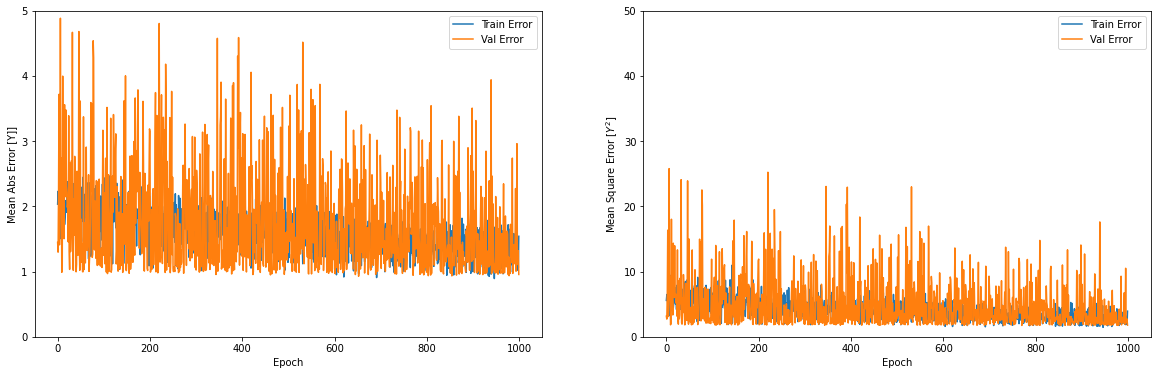

In [75]:
plot_history(history, ylim_mae=(0, 5), ylim_mse=(0, 50))

### Make predictions

#### 80일 예측 

In [0]:
test_predictions1 = model.predict(df_test[feat_temp])
test_predictions2 = model2.predict(test_predictions1)

Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_keras_scratch_graph_307564 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/d

In [0]:
# 제출 파일 만들기
submit = pd.DataFrame({'id':range(144*33, 144*113),
              'Y18':test_predictions2.reshape(1,-1)[0]})

In [0]:
submit.to_csv('baseline_result_2.csv', index = False)